# Plot CMIP ZOS fields

In [1]:
import os
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

sys.path.append('../code/')
import mod_loc as loc

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
python_data_dir = '../outputs/'
#ncl_data_dir = '../../Data_Proj/Data_CMIP5/CorrectedZOS_TS_yearly/'
#ar5_data_dir = '../../Data_Proj/Data_AR5/Ocean/1x1_glob/'
path_fig = '/Users/dewilebars/Projects/KNMIClimateScenarios2021-2023/KNMI21/projections/figures/'

In [3]:
def plot_all_models(ds):
    nb_cols = 3
    nb_rows = int(np.ceil(len(ds.model)/nb_cols))
    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_cols, figsize=(14,30))

    for idx, mod in enumerate(ds.model):
        ds['CorrectedReggrided_zos'].isel(time=-1,model=idx).plot(
            ax=axes[int(idx/nb_cols),idx%nb_cols])
    fig.tight_layout()


### Look at CMIP5 fields

In [4]:
sce = 'rcp85'
cmip5_zos = xr.open_mfdataset(f'{python_data_dir}cmip5_zos_{sce}/CMIP5_zos_{sce}_*.nc')
cmip5_zos = loc.rotate_longitude(cmip5_zos, 'lon')

In [5]:
# How many models?
len(cmip5_zos.model)

30

In [6]:
cmip5_zos

<xarray.Dataset>
Dimensions:                       (lat: 180, lon: 360, model: 30, time: 95)
Coordinates:
  * model                         (model) object 'ACCESS1-0' ... 'inmcm4'
  * lat                           (lat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                           (lon) float64 -179.5 -178.5 ... 178.5 179.5
  * time                          (time) float64 2.006e+03 2.008e+03 ... 2.1e+03
Data variables:
    CorrectedReggrided_zos        (model, time, lat, lon) float64 dask.array<chunksize=(1, 95, 180, 360), meta=np.ndarray>
    CorrectedReggrided_zos_rcp85  (model, time, lat, lon) float64 dask.array<chunksize=(30, 95, 180, 360), meta=np.ndarray>
Attributes:
    source_file:        This NetCDF file was built from ComputeOceanDynmicSea...
    creation_date:      2020-08-07 00:29
    emission_scenario:  rcp85

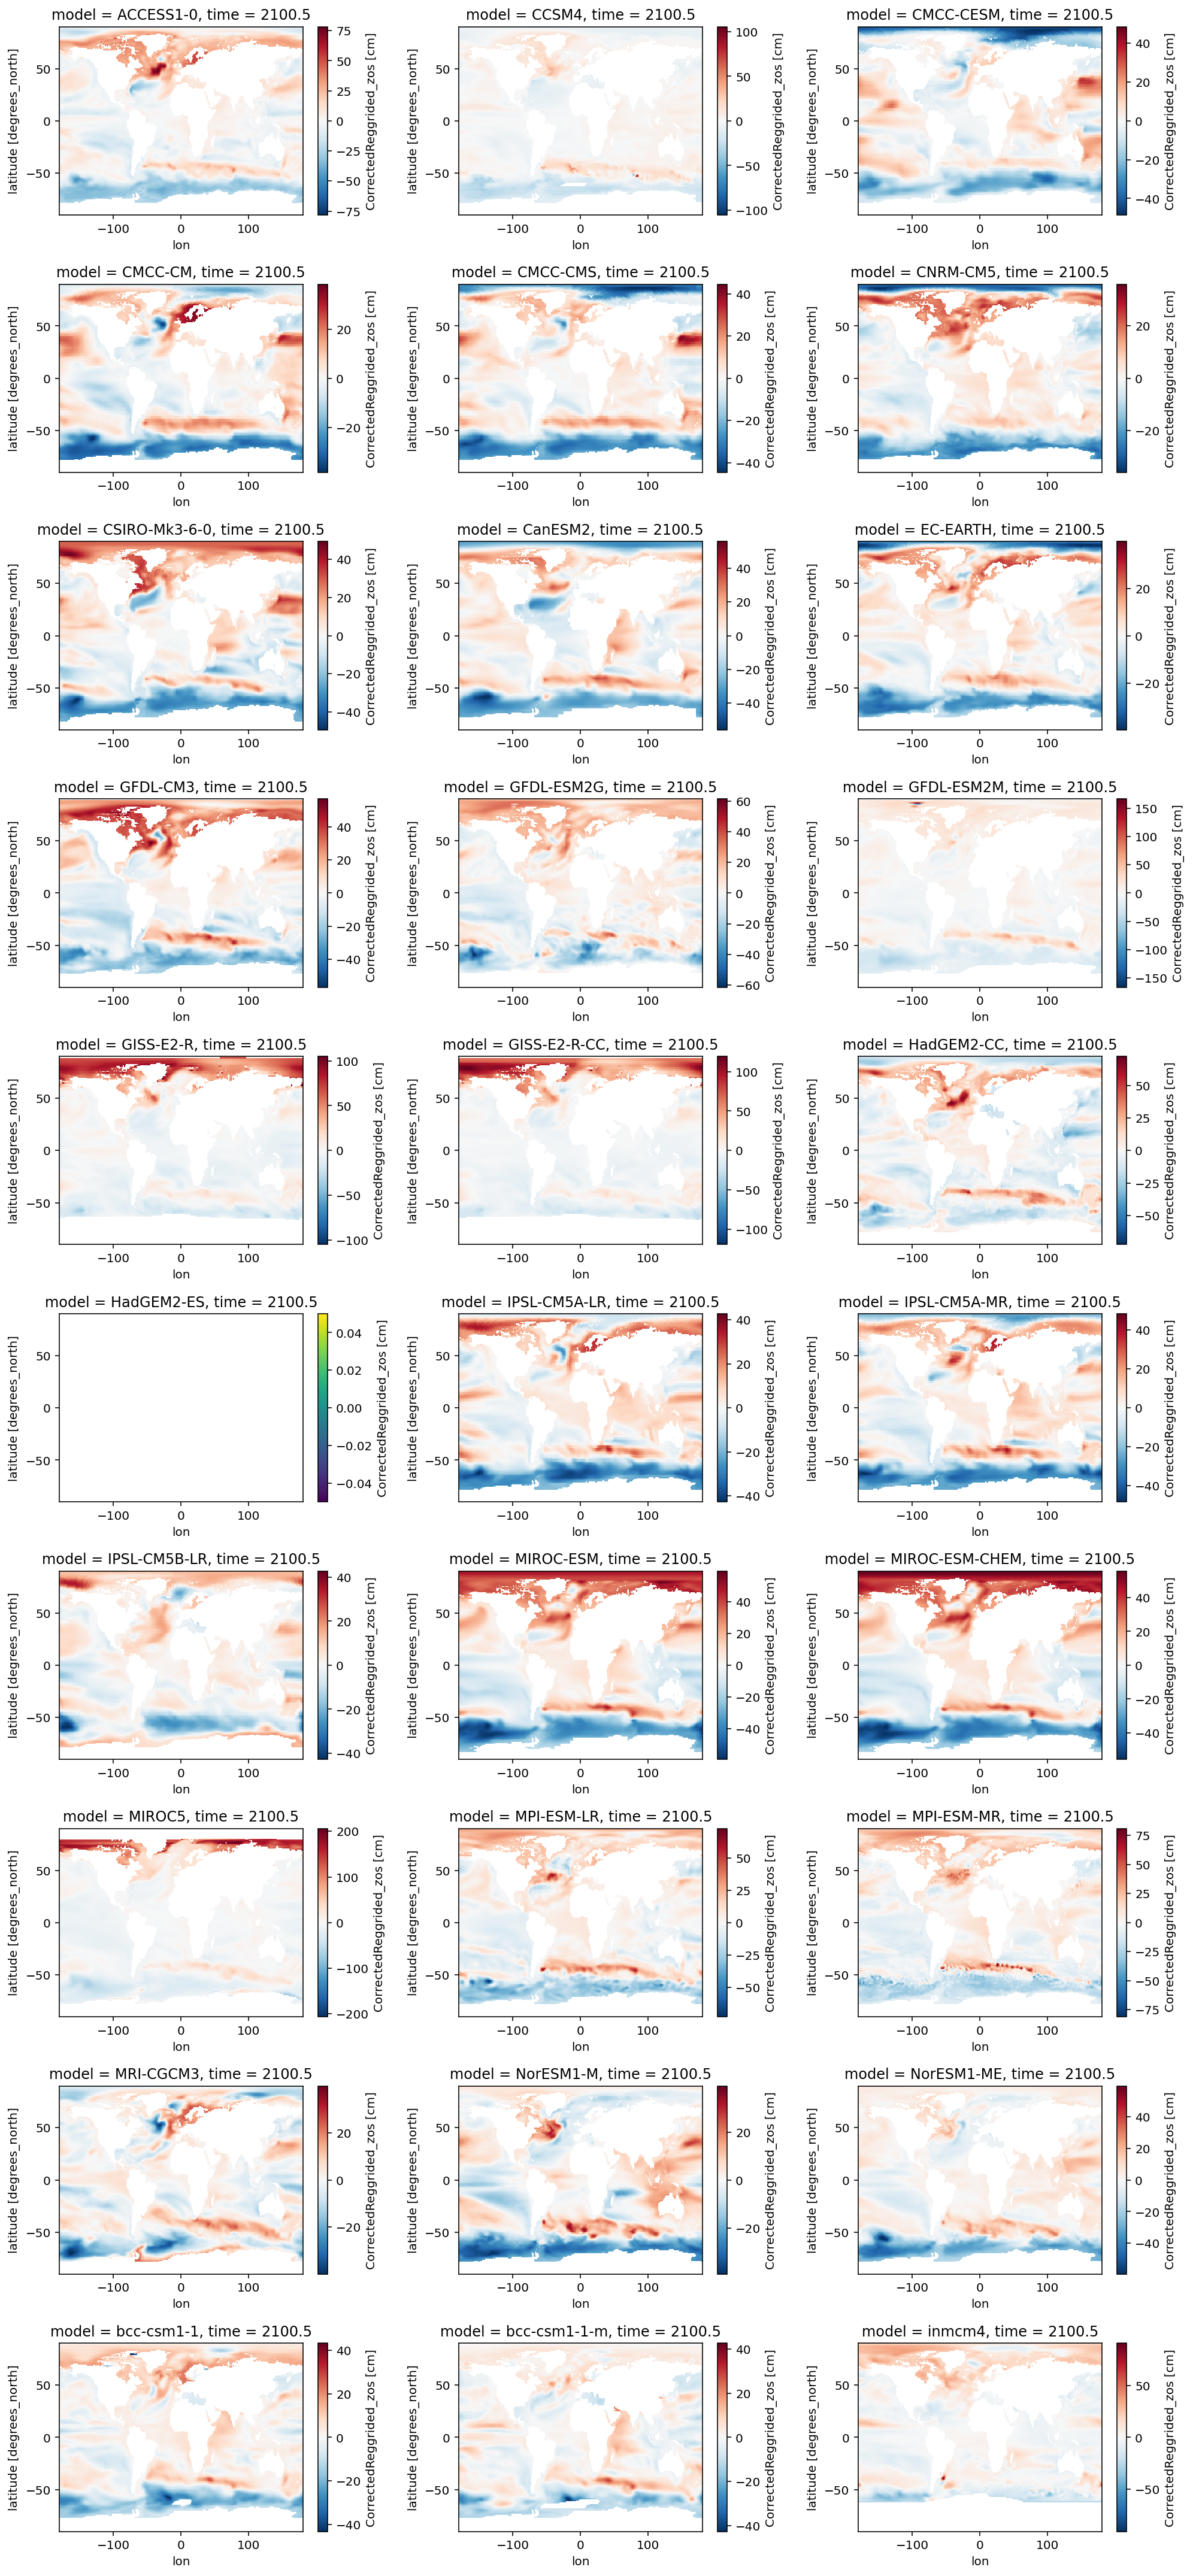

In [7]:
plot_all_models(cmip5_zos)

### Compute the mean pattern

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


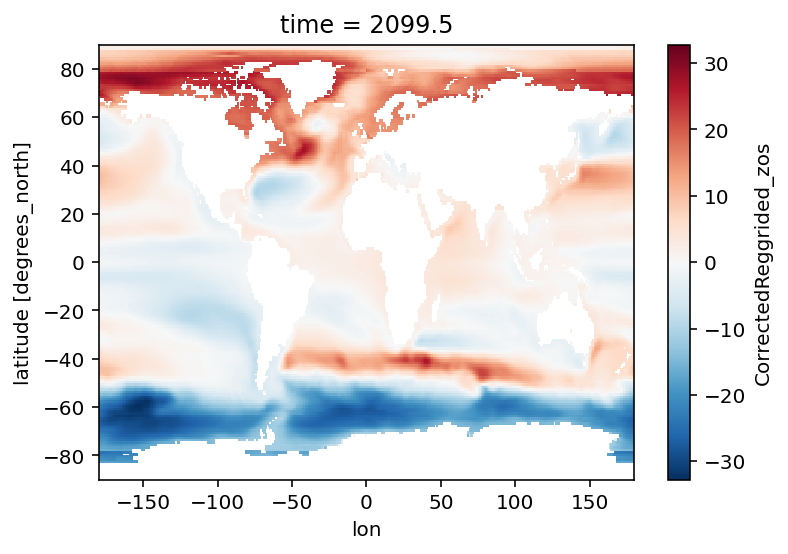

In [8]:
cmip5_zos_m = cmip5_zos['CorrectedReggrided_zos'].mean(dim='model')
cmip5_zos_m.sel(time=2099.5).plot()

### Look at CMIP6 fields

In [9]:
sce = 'ssp585'
#cmip6_zos = xr.open_mfdataset(f'{python_data_dir}cmip6_zos_{sce}/cmip6_zos_{sce}_*.nc')

hist_ds = xr.open_mfdataset(f'{python_data_dir}/cmip6_zos_historical/cmip6_zos_historical_*.nc')
sce_ds = xr.open_mfdataset(f'{python_data_dir}/cmip6_zos_{sce}/cmip6_zos_{sce}_*.nc')
cmip6_zos = xr.concat([hist_ds,sce_ds],'time').sel(model=sce_ds.model)

cmip6_zos = loc.rotate_longitude(cmip6_zos, 'lon')

In [10]:
# How many models?
len(cmip6_zos.model)

21

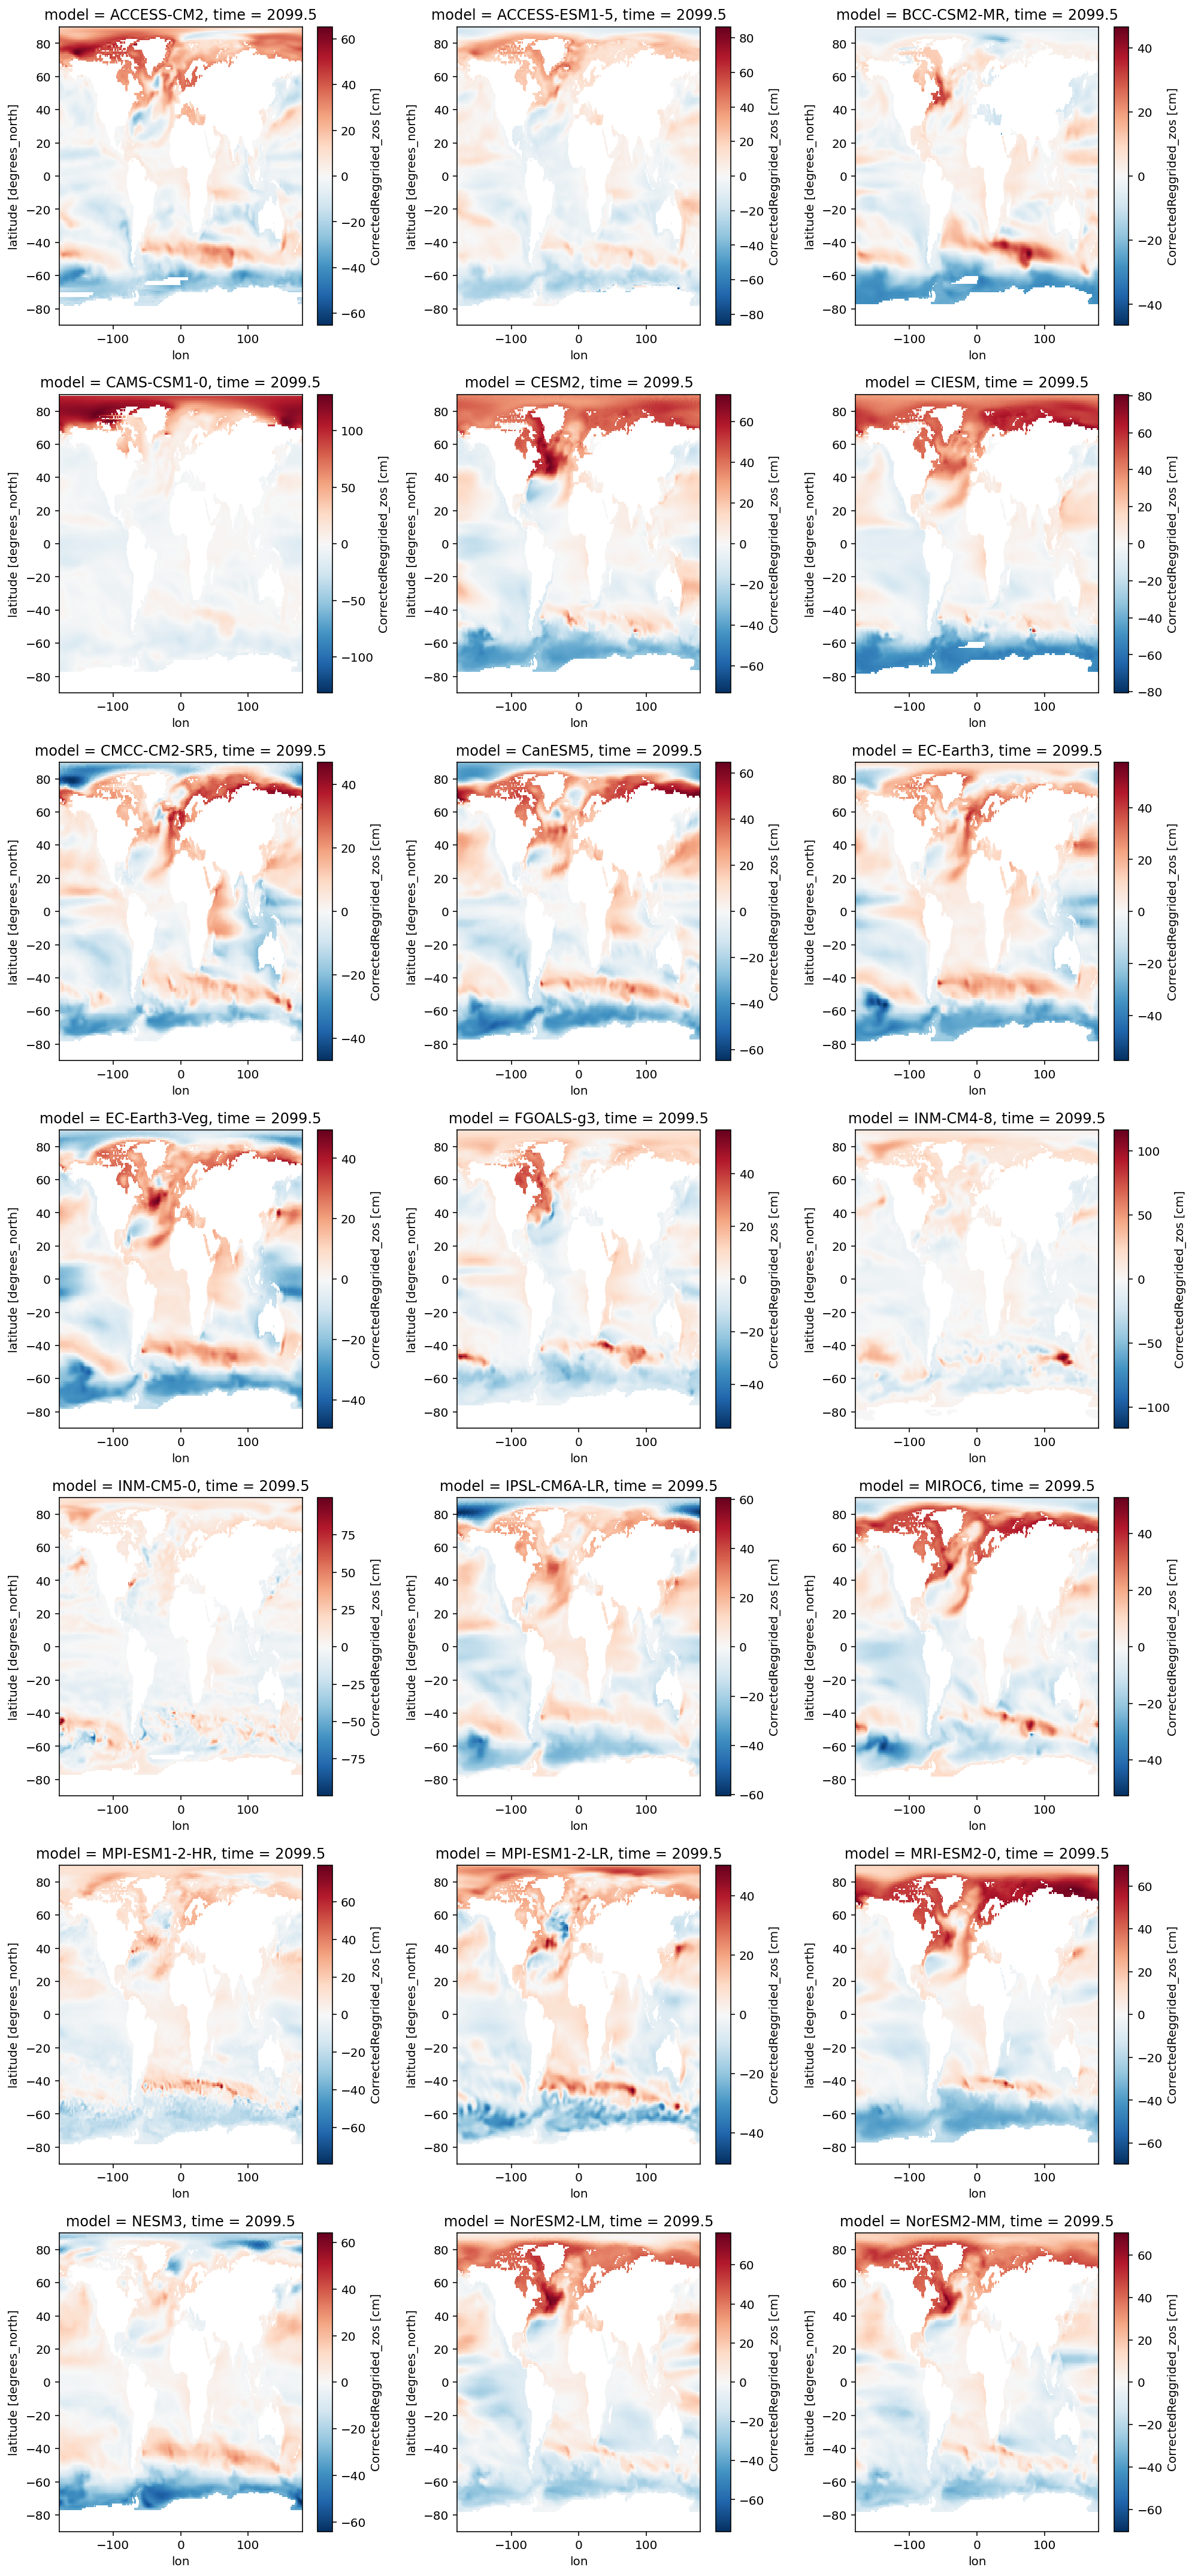

In [11]:
plot_all_models(cmip6_zos)

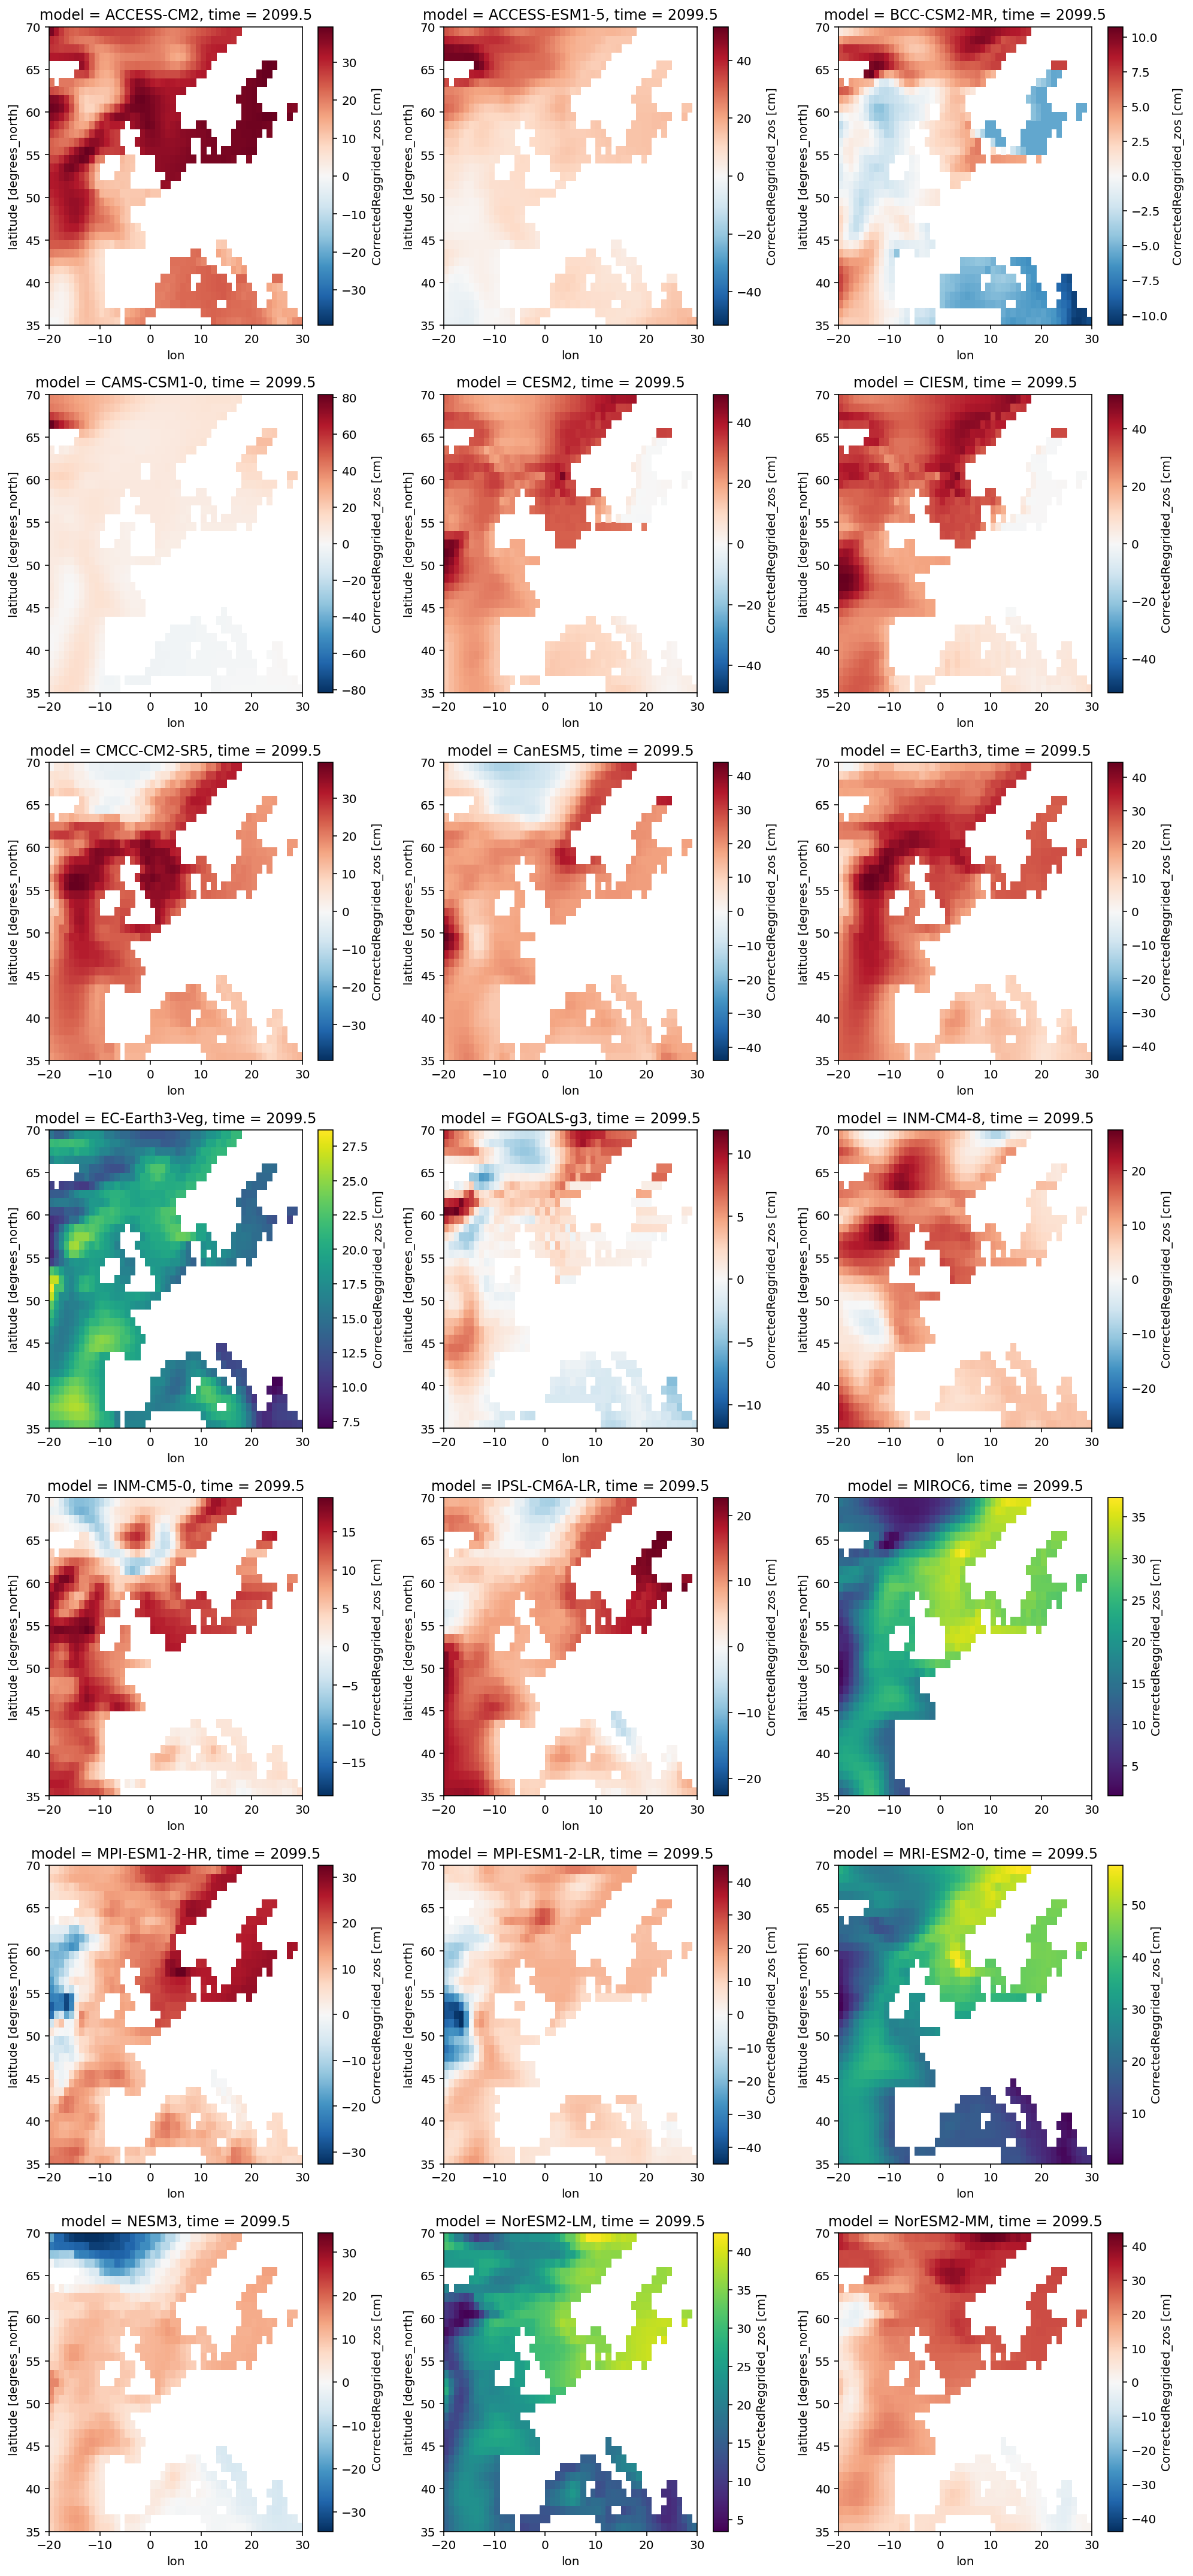

In [13]:
plot_all_models(cmip6_zos.sel(lat=slice(35,70), lon=slice(-20,30)))

### Compute the mean pattern

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


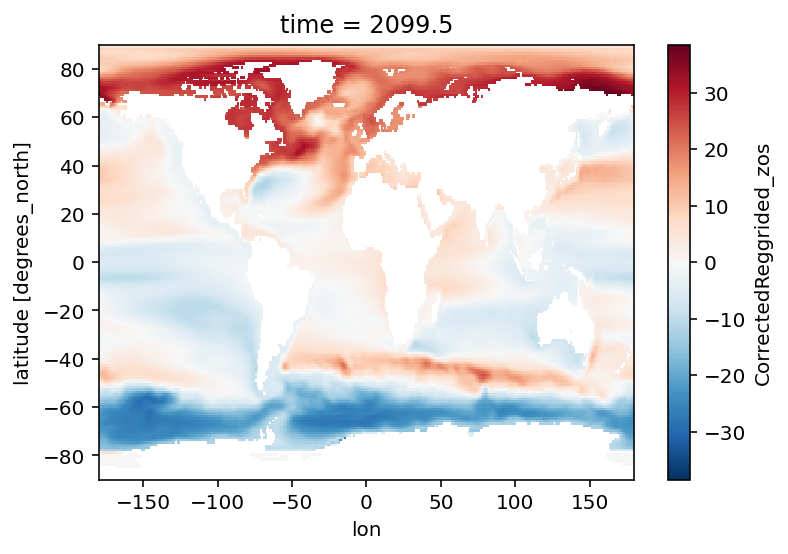

In [13]:
cmip6_zos_m = cmip6_zos['CorrectedReggrided_zos'].mean(dim='model')
cmip6_zos_m.sel(time=2099.5).plot()

### Compare the mean sea level patterns from cmip5 and cmip6

In [14]:
diff_ds = cmip6_zos_m - cmip5_zos_m

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


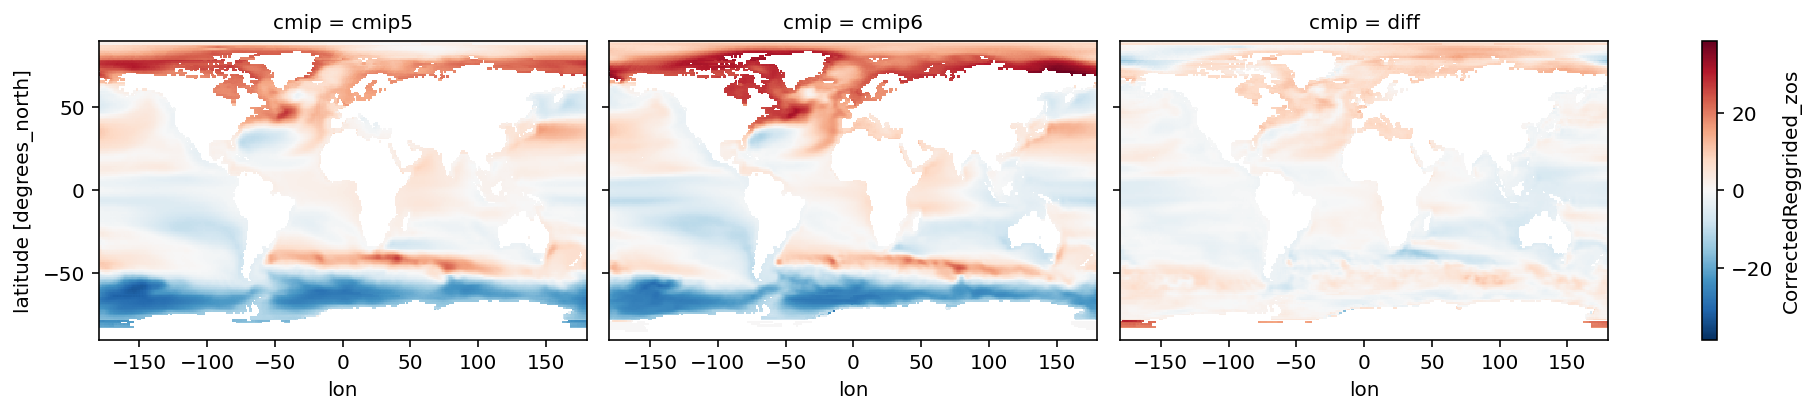

In [15]:
new_dim = xr.DataArray(['cmip5', 'cmip6', 'diff'], dims='cmip', name='cmip')
concat = xr.concat([cmip5_zos_m, cmip6_zos_m, diff_ds], dim=new_dim)
concat.sel(time=2099.5).plot(col='cmip', figsize=(14,3))

#plt.savefig('../figures/zos_comp_rcp85_ssp585_world.pdf', dpi=150)

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


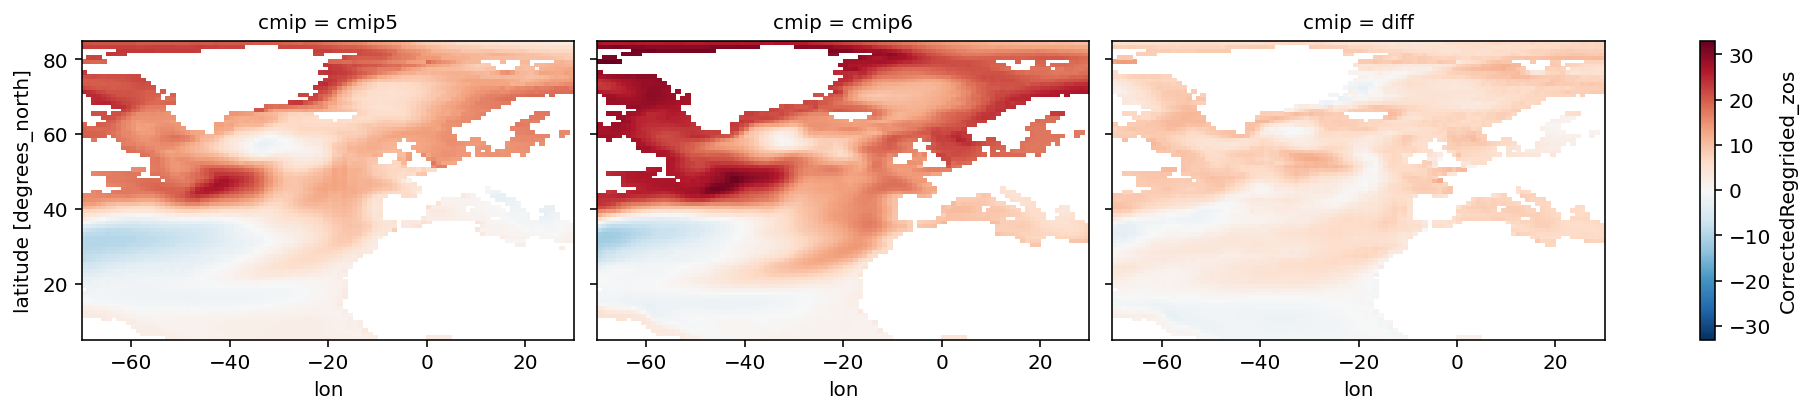

In [16]:
concat.sel(time=2099.5, lat=slice(5,85), lon=slice(-70,30)).plot(col='cmip', figsize=(14,3))

#plt.savefig('../figures/zos_comp_rcp85_ssp585_NorthAtlantic.pdf', dpi=150)

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


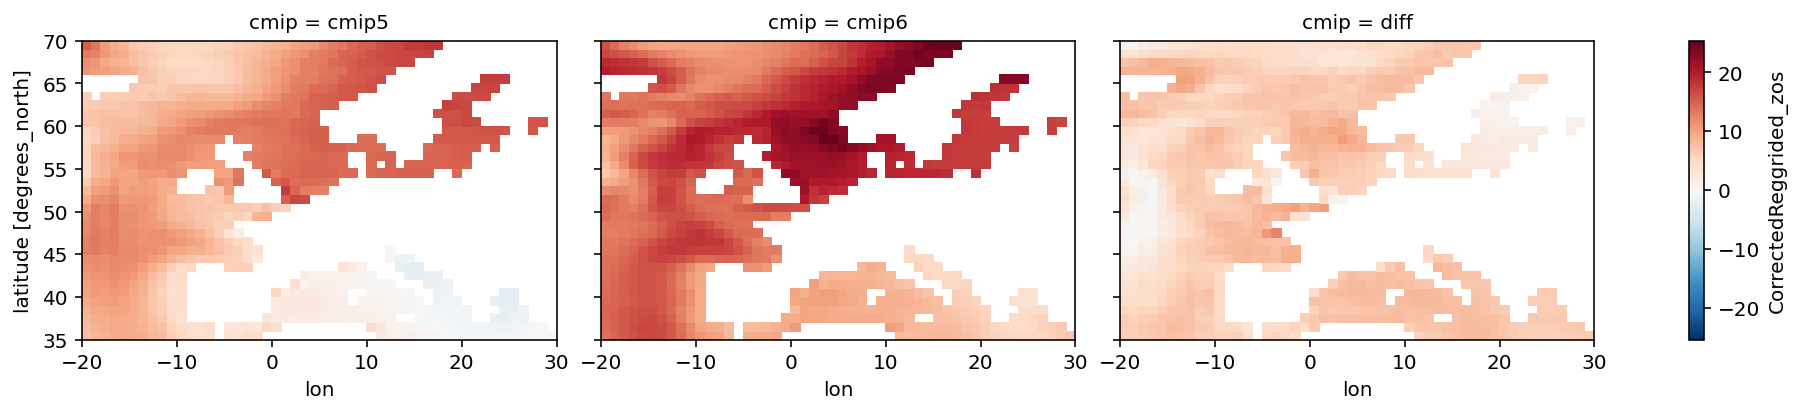

In [17]:
concat.sel(time=2099.5, lat=slice(35,70), lon=slice(-20,30)).plot(col='cmip', figsize=(14,3))

#plt.savefig('../figures/zos_comp_rcp85_ssp585_europe.pdf', dpi=150)

### Look into time series at the Dutch coast

In [18]:
def define_area(reg):
    '''Provides box coordinates given a region'''
    
    if reg == 'dutch_coast':
        lon_min, lon_max = 3, 7
        lat_min, lat_max = 51, 54
    elif reg == 'north_sea':
        lon_min, lon_max = -2, 9
        lat_min, lat_max = 48, 60
    elif reg == 'knmi14_reg':
        lon_min, lon_max = -3.5, 7.5
        lat_min, lat_max = 51, 60
    
    return lon_min, lon_max, lat_min, lat_max

start_year = 1970 #2006
end_year = 2101

In [19]:
lon_min, lon_max, lat_min, lat_max = define_area('knmi14_reg')

In [20]:
def ds2df(cmip_ds, lon_min, lon_max, lat_min, lat_max, start_year, end_year):
    '''Transform a dataset to a dataframe by averaging sea level over a region'''
    sel_ds = cmip_ds.sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
    sel_da = sel_ds['CorrectedReggrided_zos'].mean(dim=['lon','lat'])

    df = pd.DataFrame(dict(time=np.arange(start_year,end_year)+0.5))
    df = df.set_index('time')

    for mod in sel_da.model.values:
        df[mod] = sel_da.sel(model=mod).drop('model').to_dataframe()
        
    return df

In [21]:
cmip6_df = ds2df(cmip6_zos, lon_min, lon_max, lat_min, lat_max, start_year, end_year)
cmip6_df

ACCESS-CM2  ACCESS-ESM1-5  BCC-CSM2-MR  CAMS-CSM1-0      CESM2  \
time                                                                     
1970.5    5.405501      -9.123763    -3.113217     4.868692   0.272787   
1971.5    5.704158       0.476290    -1.505337     8.789115  -0.834606   
1972.5    2.619319      -4.447325    -3.877017     4.131009  -0.904244   
1973.5   -2.822723      -5.809219     2.479460     0.290758  -0.449332   
1974.5    1.539528      -0.130749    -1.039327     0.217049   0.623252   
...            ...            ...          ...          ...        ...   
2096.5   21.772556      11.864982    11.282758     4.212836  27.191700   
2097.5   25.333128       9.251408     9.846659     3.097226  31.168899   
2098.5   25.436304       9.659603     5.550642     4.368026  30.453704   
2099.5   34.437927      12.059359     2.808055     7.577799  30.925283   
2100.5         NaN            NaN          NaN          NaN        NaN   

            CIESM  CMCC-CM2-SR5    CanESM5  EC-Earth3  EC-Earth3-Veg  ...  \
time                                                                  ...   
1970.5  -3.744500     -1.478116   2.367543  -5.343027       1.377362  ...   
1971.5  -2.382752     -0.644462  -1.413090   0.672307      -0.839854  ...   
1972.5   0.956327      1.332285  -2.159450  -2.944414      -2.879337  ...   
1973.5  -1.052699     -3.156726  -2.198866  -6.217683      -2.309690  ...   
1974.5  -2.191161     -5.289926   3.092731  -1.794999      -2.523499  ...   
...           ...           ...        ...        ...            ...  ...   
2096.5  36.873973     25.013686  28.190165  24.898576      25.793631  ...   
2097.5  36.985054     27.346813  28.187645  26.894712      18.005684  ...   
2098.5  38.213129     33.159305  27.114143  26.817373      18.298441  ...   
2099.5  35.303825     32.549768  22.835630  28.432115      19.098595  ...   
2100.5        NaN           NaN        NaN        NaN            NaN  ...   

        INM-CM4-8  INM-CM5-0  IPSL-CM6A-LR     MIROC6  MPI-ESM1-2-HR  \
time                                                                   
1970.5   2.429087  -2.441318     -4.339519  -5.938215      -1.681008   
1971.5   3.011251   0.634809     -3.441096  -6.300841      -3.271463   
1972.5   5.827991   3.363564     -2.489627  -2.829730      -1.575878   
1973.5   4.636843   0.555682      1.672698  -4.752301       0.050812   
1974.5   3.170605   1.284559     -0.265818  -6.429103      -2.978845   
...           ...        ...           ...        ...            ...   
2096.5  19.716848  18.964663     15.168711  31.063117      25.928784   
2097.5  19.982444  16.554286     16.255499  29.342896      26.822267   
2098.5  17.199190  16.664007     11.535121  28.975802      26.999010   
2099.5  16.124794  13.284299     10.798786  32.283031      22.220859   
2100.5        NaN        NaN           NaN        NaN            NaN   

        MPI-ESM1-2-LR  MRI-ESM2-0      NESM3  NorESM2-LM  NorESM2-MM  
time                                                                  
1970.5      -2.131518   -2.527048   4.372003    0.836412   -8.265128  
1971.5      -2.133364    2.468516   4.322336    1.856015   -7.590601  
1972.5      -2.514262    2.055424   2.698545   -1.818245   -9.118849  
1973.5      -0.964632    0.928814   3.880778   -3.126048   -5.955150  
1974.5      -5.612455    3.000189   1.509691   -0.229302   -4.889633  
...               ...         ...        ...         ...         ...  
2096.5      14.085046   41.529810   7.500016   29.287759   19.414327  
2097.5      13.732746   42.514745   9.348266   26.564399   21.299253  
2098.5      13.360298   45.856655   7.804740   30.726472   27.976332  
2099.5      14.520849   43.116278  11.265253   32.543551   25.883013  
2100.5            NaN         NaN        NaN         NaN         NaN  

[131 rows x 21 columns]

In [22]:
cmip5_df = ds2df(cmip5_zos, lon_min, lon_max, lat_min, lat_max, start_year, end_year)
cmip5_df

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ACCESS1-0     CCSM4  CMCC-CESM    CMCC-CM   CMCC-CMS   CNRM-CM5  \
time                                                                      
1970.5        NaN       NaN        NaN        NaN        NaN        NaN   
1971.5        NaN       NaN        NaN        NaN        NaN        NaN   
1972.5        NaN       NaN        NaN        NaN        NaN        NaN   
1973.5        NaN       NaN        NaN        NaN        NaN        NaN   
1974.5        NaN       NaN        NaN        NaN        NaN        NaN   
...           ...       ...        ...        ...        ...        ...   
2096.5  29.607797  7.922522   3.958708  31.512954  16.963778  10.447077   
2097.5  28.963902  4.438567   2.827800  29.282992  18.700005  14.185214   
2098.5  23.182390 -4.521353   5.785284  30.336887  22.579167  12.911133   
2099.5  29.601288  1.111813   9.567133  31.407025  15.693716  16.148842   
2100.5  33.560725  5.980581   9.568995  30.560567  16.003061  16.353343   

        CSIRO-Mk3-6-0   CanESM2   EC-EARTH   GFDL-CM3  ...  MIROC-ESM-CHEM  \
time                                                   ...                   
1970.5            NaN       NaN        NaN        NaN  ...             NaN   
1971.5            NaN       NaN        NaN        NaN  ...             NaN   
1972.5            NaN       NaN        NaN        NaN  ...             NaN   
1973.5            NaN       NaN        NaN        NaN  ...             NaN   
1974.5            NaN       NaN        NaN        NaN  ...             NaN   
...               ...       ...        ...        ...  ...             ...   
2096.5       9.372843  1.961126  18.106114  25.119993  ...       23.611012   
2097.5       9.677474  1.912960  18.788645  21.684745  ...       27.740982   
2098.5       7.356769  2.774823  19.179581  20.744272  ...       26.691721   
2099.5       4.631558  2.401447  18.153121  20.797154  ...       23.157921   
2100.5      14.153699  0.521896  18.882529  21.702204  ...       24.088518   

           MIROC5  MPI-ESM-LR  MPI-ESM-MR  MRI-CGCM3  NorESM1-M  NorESM1-ME  \
time                                                                          
1970.5        NaN         NaN         NaN        NaN        NaN         NaN   
1971.5        NaN         NaN         NaN        NaN        NaN         NaN   
1972.5        NaN         NaN         NaN        NaN        NaN         NaN   
1973.5        NaN         NaN         NaN        NaN        NaN         NaN   
1974.5        NaN         NaN         NaN        NaN        NaN         NaN   
...           ...         ...         ...        ...        ...         ...   
2096.5  27.004613    8.402209   20.723305  22.393141  -2.129309   -0.588395   
2097.5  28.274644   11.320462   18.074946  25.707589  -2.142463   -5.029265   
2098.5  28.914477   11.669660   19.708019  22.790518  -2.849316   -4.688030   
2099.5  31.432388   11.981793   21.748047  20.222313  -5.389053   -5.221285   
2100.5  29.479419   14.760943   19.458370  19.662913  -3.344565   -3.150534   

        bcc-csm1-1  bcc-csm1-1-m     inmcm4  
time                                         
1970.5         NaN           NaN        NaN  
1971.5         NaN           NaN        NaN  
1972.5         NaN           NaN        NaN  
1973.5         NaN           NaN        NaN  
1974.5         NaN           NaN        NaN  
...            ...           ...        ...  
2096.5   19.613454      7.114775  17.494954  
2097.5   14.508022      4.073269  13.461390  
2098.5   13.469174      2.449303  15.024123  
2099.5   20.191509      4.086868  13.769985  
2100.5   22.049114      8.701088  14.379105  

[131 rows x 30 columns]

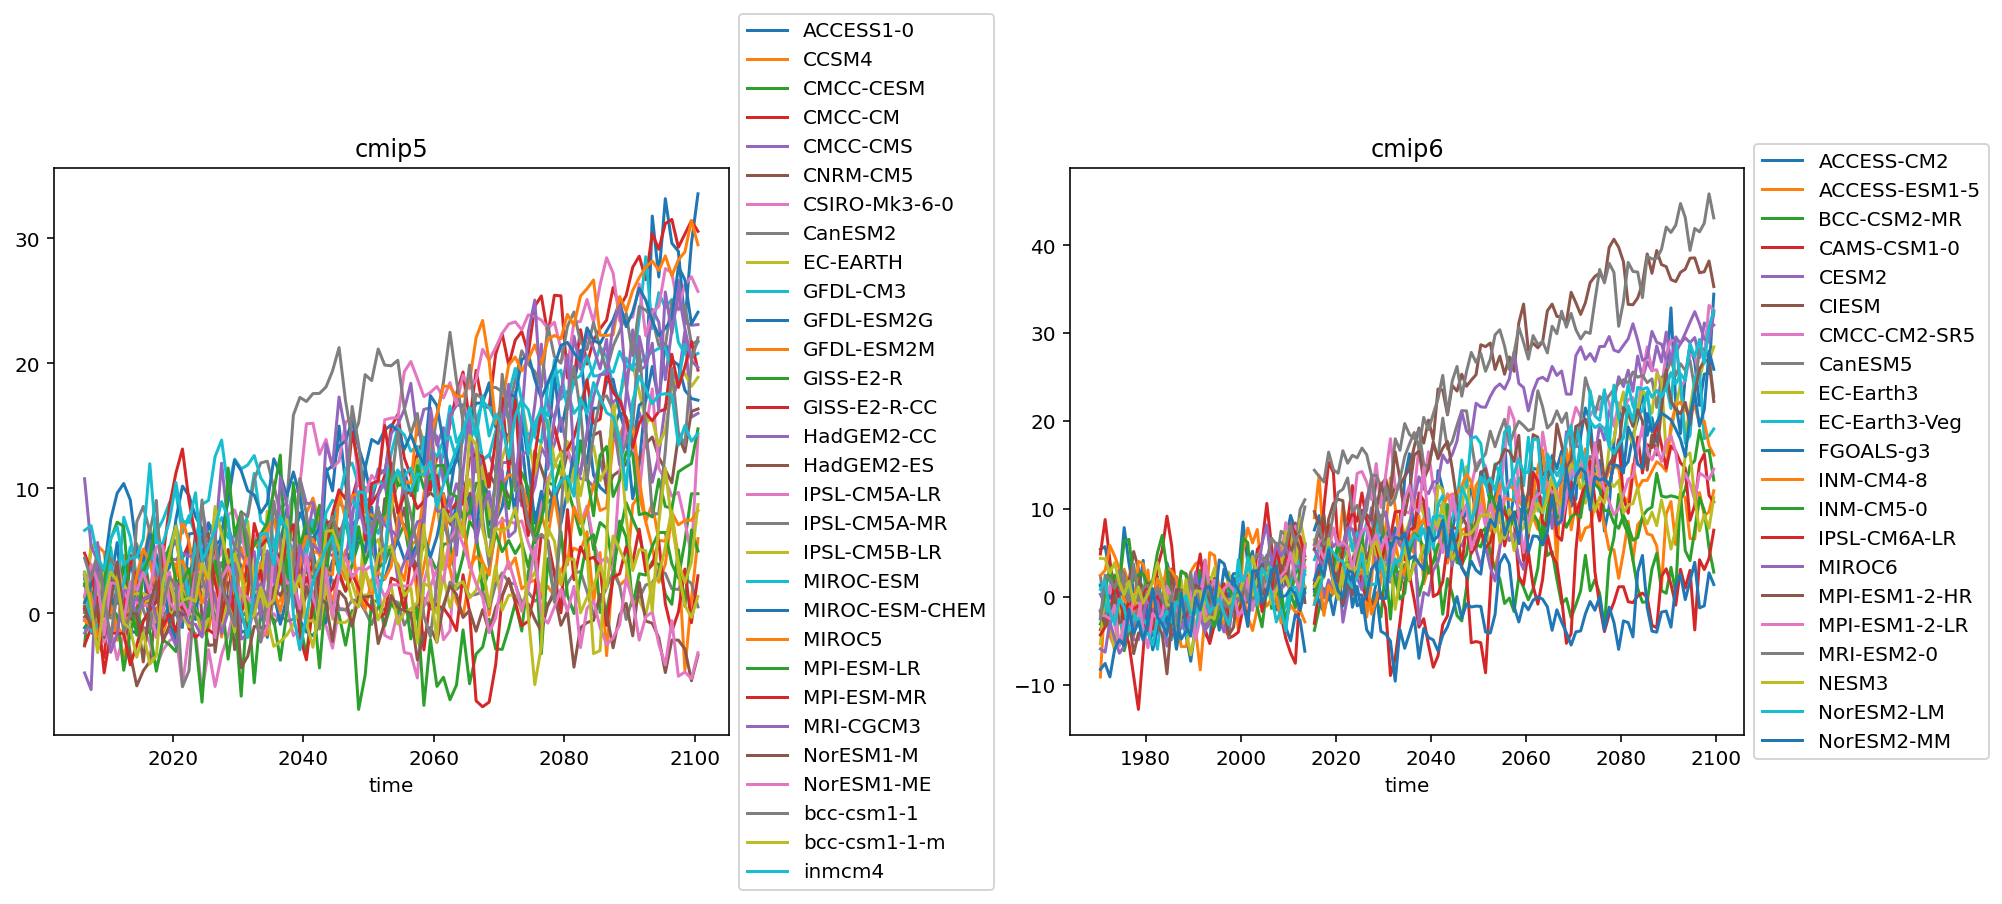

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

cmip5_df.plot(ax=axes[0], title='cmip5').legend(loc='center left', bbox_to_anchor=(1, 0.5))
cmip6_df.plot(ax=axes[1], title='cmip6').legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

### Check the value distribution in 2090-2100

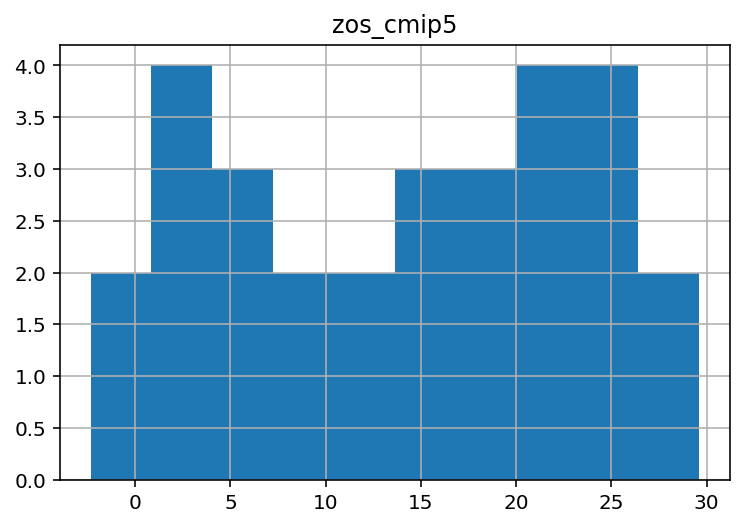

In [24]:
cmip5_2090_2100_df = pd.DataFrame(cmip5_df.loc[2090.5:2099.5].mean(axis=0), columns=['zos_cmip5'] )
cmip5_2090_2100_df.index.name = 'model'
cmip5_hist = cmip5_2090_2100_df.hist(bins=10)

array([[<AxesSubplot:title={'center':'zos_cmip6'}>]], dtype=object)

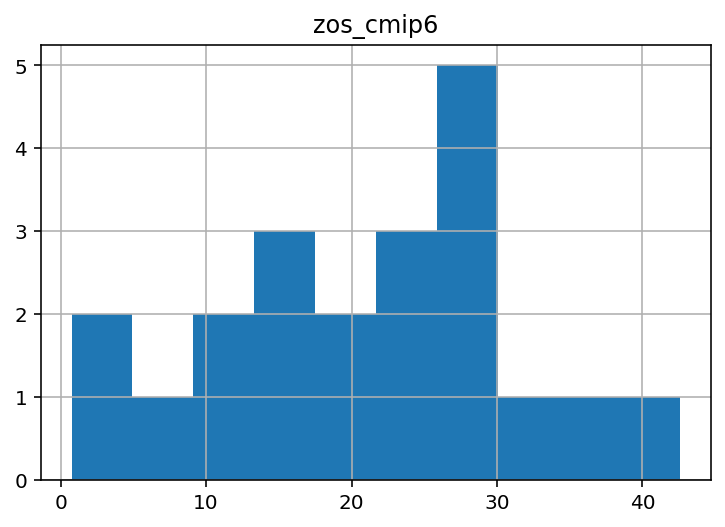

In [25]:
cmip6_2090_2100_df = pd.DataFrame(cmip6_df.loc[2090.5:2099.5].mean(axis=0), columns=['zos_cmip6'] )
cmip6_2090_2100_df.index.name = 'model'
cmip6_2090_2100_df.hist(bins=10)

### Check the mean and likely range

In [26]:
stat_df = pd.DataFrame(cmip5_df.mean(axis=1), columns=['cmip5_mean'] )
stat_df['cmip5_std'] = cmip5_df.std(axis=1)
stat_df['cmip5_95pc'] = stat_df['cmip5_mean'] + 1.64*stat_df['cmip5_std']
stat_df['cmip5_5pc'] = stat_df['cmip5_mean'] - 1.64*stat_df['cmip5_std']
stat_df['cmip6_mean'] = cmip6_df.mean(axis=1)
stat_df['cmip6_std'] = cmip6_df.std(axis=1)
stat_df['cmip6_95pc'] = stat_df['cmip6_mean'] + 1.64*stat_df['cmip6_std']
stat_df['cmip6_5pc'] = stat_df['cmip6_mean'] - 1.64*stat_df['cmip6_std']


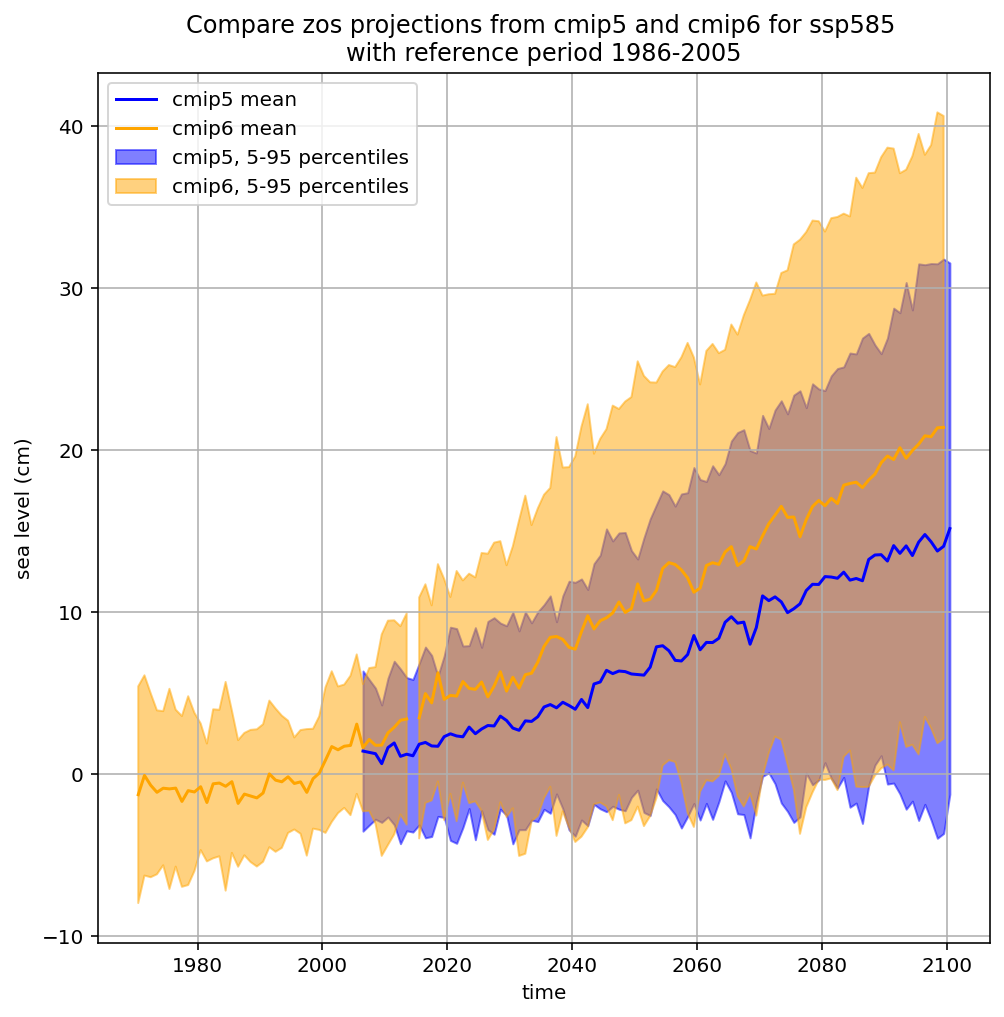

In [27]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(stat_df.index, stat_df['cmip5_95pc'], 
                stat_df['cmip5_5pc'], color='blue',alpha=0.5,
               label='cmip5, 5-95 percentiles')
ax.fill_between(stat_df.index, stat_df['cmip6_95pc'], 
                stat_df['cmip6_5pc'], color='orange',alpha=0.5,
               label='cmip6, 5-95 percentiles')
ax.plot(stat_df['cmip5_mean'], color='blue', label='cmip5 mean')
ax.plot(stat_df['cmip6_mean'], color='orange', label='cmip6 mean')

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title(f'Compare zos projections from cmip5 and cmip6 for {sce} \n'+
         'with reference period 1986-2005')
ax.grid(True)
plt.legend(loc='upper left')

plt.savefig('../figures/zos_comp_rcp85_ssp585_DutchCoast_ts.pdf', dpi=150)

In [28]:
stat_df.loc[2090.5:2099.5].mean(axis=0)

cmip5_mean    13.971134
cmip5_std      9.832084
cmip5_95pc    30.095752
cmip5_5pc     -2.153484
cmip6_mean    20.352891
cmip6_std     11.246587
cmip6_95pc    38.797294
cmip6_5pc      1.908489
dtype: float64

In [29]:
stat_df.loc[2099.5]

cmip5_mean    14.060079
cmip5_std     10.815338
cmip5_95pc    31.797233
cmip5_5pc     -3.677076
cmip6_mean    21.402901
cmip6_std     11.727208
cmip6_95pc    40.635523
cmip6_5pc      2.170280
Name: 2099.5, dtype: float64

### Temporal evolution of the standard deviations

<AxesSubplot:xlabel='time'>

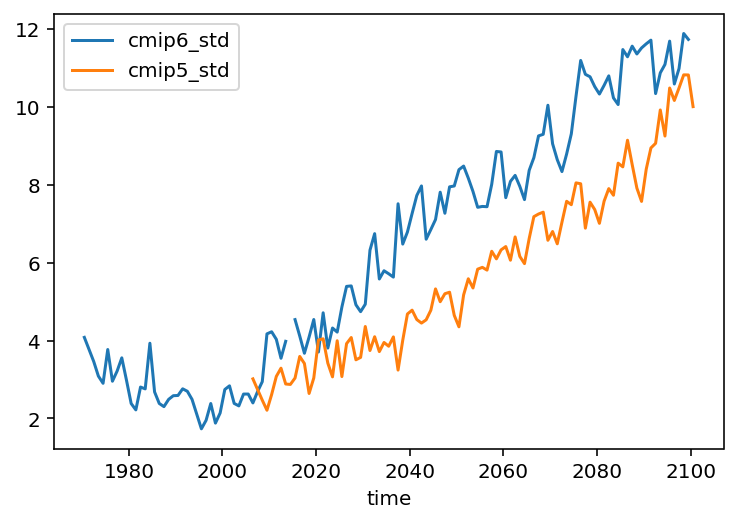

In [30]:
stat_df[['cmip6_std', 'cmip5_std']].plot()

### Compare with budget

In [31]:
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'
budget_df = pd.read_csv(path_slb+
                        'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]

Total  LocSteric  GloSteric       GIA  Glaciers  Antarctica  \
time                                                                    
2009   8.016171   3.552064   2.508173  1.105000  1.194167    0.370833   
2010   8.003000   4.389224   2.463398  1.141833  1.259167    0.446667   
2011   9.988545   4.781370   2.577349  1.178667  1.286667    0.466667   
2012   7.799622   2.654583   2.741227  1.215500  1.289167    0.491667   
2013   5.084063   3.520389   2.934533  1.252333  1.345833    0.561667   
2014   8.918411   4.540554   3.090276  1.289167  1.401667    0.626667   
2015  10.947002   3.255820   3.297743  1.326000  1.474167    0.721667   
2016   7.910991   3.790802   3.270519  1.362833  1.528333    0.692500   
2017  13.661746   5.137556   3.428105  1.399667  1.600000    0.708333   
2018   6.453903   3.318551   3.479624  1.436500  1.620000    0.816667   

      Greenland       TWS     Nodal      Wind  Pressure        Obs  
time                                                                
2009   0.088333  0.188333  0.892339 -1.090116 -0.792955   5.600000  
2010   0.100833  0.367500  0.735257 -2.354945 -0.545934   4.766667  
2011   0.103333 -0.016667  0.555900  1.935137 -2.879877   8.250000  
2012   0.115833  0.316667  0.374518  0.184546 -1.584085   7.300000  
2013   0.125000  0.511667  0.211591 -3.656733 -1.722219   4.800000  
2014   0.130833  0.240000  0.085516 -2.865864  0.379595   8.900000  
2015   0.144167  0.465000  0.010529  3.470097 -3.218186  11.483333  
2016   0.157500  0.675000 -0.004905 -1.330948 -2.230644   9.933333  
2017   0.165000  0.130833  0.040957  3.277656 -2.226363  13.450000  
2018   0.172500  0.003333  0.142938 -2.535236 -2.000975   6.166667

In [32]:
budget_LocOcean = (budget_df['LocSteric'] + budget_df['Nodal'] + 
                   budget_df['Wind'] +  budget_df['Pressure'])
budget_LocOcean = budget_LocOcean - budget_LocOcean.loc[1986:2005].mean()

budget_LocSteric_Wind = (budget_df['LocSteric'] + budget_df['Wind'])
budget_LocSteric_Wind = budget_LocSteric_Wind - budget_LocSteric_Wind.loc[1986:2005].mean()

In [33]:
#regions: dutch_coast, north_sea, knmi14_reg
lon_min, lon_max, lat_min, lat_max = define_area('knmi14_reg')

cmip6_df = ds2df(cmip6_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)
cmip5_df = ds2df(cmip5_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [34]:
cmip6_mean_df = cmip6_df.mean(axis=1)
cmip5_mean_df = cmip5_df.mean(axis=1)

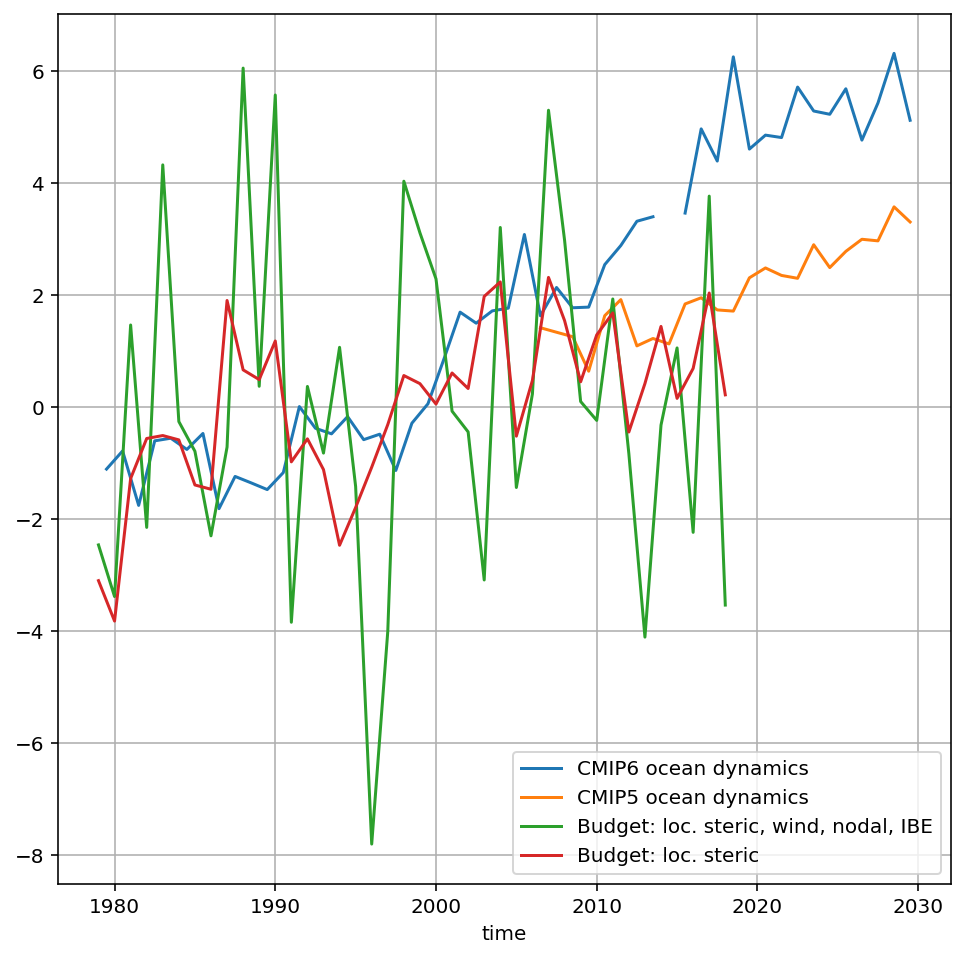

In [35]:
fig, ax = plt.subplots(figsize=(8,8))

cmip6_mean_df.plot(legend=True, label='CMIP6 ocean dynamics')
cmip5_mean_df.plot(legend=True, label='CMIP5 ocean dynamics')
budget_LocOcean.plot(legend=True, label='Budget: loc. steric, wind, nodal, IBE')
(budget_df['LocSteric']- budget_df['LocSteric'].loc[1986:2005].mean() ).plot(legend=True, label='Budget: loc. steric')

ax.grid(True)

#plt.savefig(path_fig+'comp_ocean_dynamics.pdf', dpi=150)

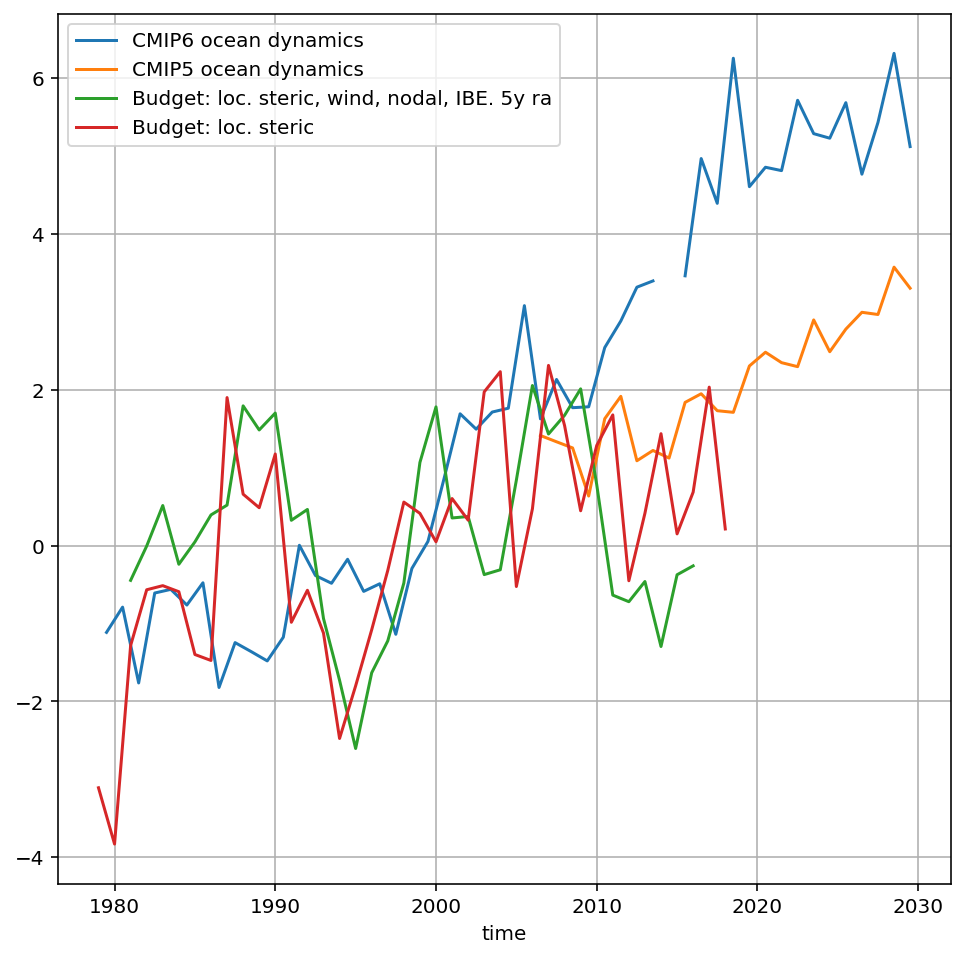

In [36]:
fig, ax = plt.subplots(figsize=(8,8))

cmip6_mean_df.plot(legend=True, label='CMIP6 ocean dynamics')
cmip5_mean_df.plot(legend=True, label='CMIP5 ocean dynamics')
budget_LocOcean.rolling(5, center=True).mean().plot(legend=True, label='Budget: loc. steric, wind, nodal, IBE. 5y ra')
(budget_df['LocSteric']- budget_df['LocSteric'].loc[1986:2005].mean() ).plot(legend=True, label='Budget: loc. steric')

ax.grid(True)

plt.savefig(path_fig+'comp_ocean_dynamics_smoother.pdf', dpi=150)

### Compute the mismatch between CMIP6 and observations

In [136]:
start_y = 1986 #1986 #1979
end_y = 2018

trend_LocSteric_Wind = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_LocSteric_Wind.loc[start_y:end_y], 1)[0]
trend_LocSteric_Wind

-0.00714455457256859

In [137]:
trend_LocSteric = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_df['LocSteric'].loc[start_y:end_y], 1)[0]
trend_LocSteric

0.049161214342159414

In [138]:
trend_Wind = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_df['Wind'].loc[start_y:end_y], 1)[0]
trend_Wind

-0.056305768914727994

In [139]:
trend_Press = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_df['Pressure'].loc[start_y:end_y], 1)[0]
trend_Press

0.00960994693128683

In [162]:
cmip6_mean_df[2014.5] = cmip6_mean_df[2013.5]+cmip6_mean_df[2015.5]/2
trend_zos_cmip6 = np.polyfit(np.arange(start_y,end_y+1), 
                           cmip6_mean_df.loc[start_y:end_y+1], 1)[0]
trend_zos_cmip6

0.18641079845545266

In [163]:
# Compute the bias arising from the mismatch between observed and modelled dynamics
start_y = 1979 #1986 #1979
end_y = 2018

bias_dynamics = linregress(np.arange(start_y,end_y+1), 
                 cmip6_mean_df.loc[start_y:end_y+1].values-
                 budget_LocSteric_Wind.loc[start_y:end_y].values)
print(f'The linear trend bias (in mm/year) for the period {start_y}-{end_y} is:')
print(bias_dynamics.slope*10)
print(f'with an standard error:')
print(bias_dynamics.stderr*10)

The linear trend bias (in mm/year) for the period 1979-2018 is:
1.3170712377741496
with an standard error:
0.4179483014661039


In [164]:
start_y = 1986 #1986 #1979
end_y = 2018

bias_dynamics = linregress(np.arange(start_y,end_y+1), 
                 cmip6_mean_df.loc[start_y:end_y+1].values-
                 budget_LocSteric_Wind.loc[start_y:end_y].values)
print(f'The linear trend bias (in mm/year) for the period {start_y}-{end_y} is:')
print(bias_dynamics.slope*10)
print(f'with an standard error:')
print(bias_dynamics.stderr*10)

The linear trend bias (in mm/year) for the period 1986-2018 is:
1.935553530280323
with an standard error:
0.5448257514767436


In [165]:
# Now instead of a linear trend bias, we compute a scaling factor
start_y = 1979 #1986 #1979
end_y = 2018

trend_LocSteric_Wind = linregress(np.arange(start_y,end_y+1), 
                                   budget_LocSteric_Wind.loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind and loc steric (mm/year) is:')
print(trend_LocSteric_Wind*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric_Wind/trend_zos_cmip6)


Trend in observed wind and loc steric (mm/year) is:
0.17959259450720674
Trend in CMIP6 zos is:
1.4966638322813564
Scaling factor:
0.1199952792561672


In [166]:
start_y = 1986 #1986 #1979
end_y = 2018

trend_LocSteric_Wind = linregress(np.arange(start_y,end_y+1), 
                                   budget_LocSteric_Wind.loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind and loc steric (mm/year) is:')
print(trend_LocSteric_Wind*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric_Wind/trend_zos_cmip6)

Trend in observed wind and loc steric (mm/year) is:
-0.07144554572574635
Trend in CMIP6 zos is:
1.864107984554576
Scaling factor:
-0.03832693509052164


In [167]:
# Scaling factor assuming wind in observations is due to natural variability
start_y = 1979 #1986 #1979
end_y = 2018

trend_LocSteric = linregress(np.arange(start_y,end_y+1), 
                        budget_df['LocSteric'].loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind (mm/year) is:')
print(trend_LocSteric*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric/trend_zos_cmip6)

Trend in observed wind (mm/year) is:
0.7287594874781527
Trend in CMIP6 zos is:
1.4966638322813564
Scaling factor:
0.4869226286889746


In [168]:
# Scaling factor assuming wind in observations is due to natural variability
start_y = 1986 #1986 #1979
end_y = 2018

trend_LocSteric = linregress(np.arange(start_y,end_y+1), 
                        budget_df['LocSteric'].loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind (mm/year) is:')
print(trend_LocSteric*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric/trend_zos_cmip6)

Trend in observed wind (mm/year) is:
0.49161214342158416
Trend in CMIP6 zos is:
1.864107984554576
Scaling factor:
0.2637251422637158
